#### LLD - lateral log profunda
#### LLS - lateral log rasa
## Imports

In [ ]:
# Importa a biblioteca dlisio para lidar com dados em formato dlis
!pip install dlisio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 730.2/730.2 kB 7.7 MB/s eta 0:00:00


In [1]:
# Importa outras bibliotecas que serão utilizadas e
# define algumas opcões de formatação
import glob
from dlisio import dlis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import matplotlib.patches as mpatches
#import lasio

pd.set_option('display.float_format', lambda x: '%.4f' % x)

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 20)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
#pd.set_option('display.precision', 3)

ModuleNotFoundError: No module named 'seaborn'

## DLIS
- Leitura dos arquivos na pasta dlis a partir do mesmo diretório desse notebook

In [ ]:
# Cria três listas para armazenar conteúdo extraído da leitura
# dos arquivos no formato dlis
dli = []
filenames= []
poços = []
for file in glob.glob(r'**/dlis' + "/*.dlis", recursive=True):
  # print the path name of selected files
    leitura, *tail = dlis.load(f'{file}')
    poços.append(file[5:14])
    filenames.append(file)
    dli.append(leitura)

poços[-1] = poços[-1][:8]

IndexError: list index out of range

In [ ]:
# Busca por objetos na lista dlis do tipo ‘Frame’ com identificador ‘50’
frame = []
for file in dli:
    frame.append(file.object('FRAME', '50'))

NameError: name 'dli' is not defined

- Guardando os dados dos poços em um DataFrame do pandas. São guardadas somentes as curvas de interesse.
- TDEP | GR | NPHI | RHOB | DRHO | PE | CALI | DTC | HDRS | HMRS | TENS | BSZ

In [ ]:
# Cria pandas dataframes respectivos às curvas selecionadas e
# adiciona esses dataframes na lista ‘dlis_df’.
# Ordena esses dados em função da profundidade e transforma valores -999.25 em nulos
dlis_df = []


i = 0
#lista das curvas não utilizadas
lista_not = ['WF11', 'AHV', 'AHVT', 'BHV', 'BHVT', 'CS', 'FCPS', 'HDCN', 'HMCN', 'ITT', 'ITTT', 'LSPD', 'MMK', 'NCPS', 'SP']
for data in frame:
    try:
        channel_dict = [x.name for x  in data.channels if x.name not in lista_not]
        curves = data.curves()
        dlis_df.append(pd.DataFrame(curves[channel_dict]))
        #ordena em função da profundidade e transforma os valores -999.25 em nulos
        dlis_df[-1].sort_values('TDEP', inplace = True)
        dlis_df[-1].reset_index(drop = True, inplace = True)
        dlis_df[-1].replace([-999.25], [None], inplace = True)
        dlis_df[-1].replace([-999.25], [None], inplace = True)
        dlis_df[-1] = dlis_df[-1].round(4)
        dlis_df[-1]['Poco'] = poços[i]
    except:
        pass
    i+=1

## Renomeando a coluna BS para BSZ

### Transformando em % os NPHI que estão entre 0 e 1

In [ ]:
# Transforma o perfil neutrônico em porcentagem e renomeia a coluna ‘BS’ para ‘BSZ’
def alteracoesNosDados(dlis_df):
    dlis_df[0].rename(columns={'BS': 'BSZ'}, inplace = True)
    dlis_df[0]["NPHI"] = (dlis_df[0]["NPHI"] * 100)
    dlis_df[1]["NPHI"] = (dlis_df[1]["NPHI"] * 100)
    dlis_df[5]["NPHI"] = (dlis_df[5]["NPHI"] * 100)

alteracoesNosDados(dlis_df)

IndexError: list index out of range

## Acrescentando Nivel Geologico

In [ ]:
# Rotula manualmente a profundidade dos níveis geológicos
profundidades = [
    [4, 306, 348], # [TQR, OIT, IBU]
    [4, 87, 134, 205, 1000], # [TQR, MAR, TQR, MAR, MAR, OIT, IBU]
    [4, 96, 135, 194, 1000], # [TQR, MAR, TQR, MAR, MAR, OIT, IBU]
    [4, 78, 124, 162, 1000], # [TQR, MAR, TQR, MAR, MAR, OIT, IBU]
    [4, 124, 172, 238, 1000], # [TQR, MAR, TQR, MAR, MAR, OIT, IBU]
    [4, 118, 150, 212, 314], # [TQR, MAR, TQR, MAR, MAR, OIT, IBU]
]

In [ ]:
# Cria uma coluna ‘n_geo’ para cada dataframe da lista ‘dlis_df’.
# Essa coluna é composta pelos valores da lista ‘values’ que foram
# atribuídos com base nas condições especificadas na lista ‘conditions’

# Lista de valores que queremos atribuir para cada condição
#TQR = Taquari
#MAR = Maruim
#OIT =
#IBU = Ibura
values = ['TQR',  'MAR', 'TQR', 'MAR' , 'MAR', 'OIT', 'IBU']

# cria uma nova coluna e usa o np.select para atribuir o valor usando a lista como argumento
for i in range (1,6):
    conditions = [
    ((dlis_df[i]['TDEP'] >= profundidades[i][0]) & (dlis_df[i]['TDEP'] < profundidades[i][1])),
    (dlis_df[i]['TDEP'] == profundidades[i][2]),
    ((dlis_df[i]['TDEP'] >= profundidades[i][2]) & (dlis_df[i]['TDEP'] < profundidades[i][3])),
    (dlis_df[i]['TDEP'] == profundidades[i][1]),
    (dlis_df[i]['TDEP'] >= profundidades[i][1]) & (dlis_df[i]['TDEP'] < profundidades[i][2]),
    (dlis_df[i]['TDEP'] >= profundidades[i][3]) & (dlis_df[i]['TDEP'] < profundidades[i][4]),
    (dlis_df[i]['TDEP'] >= profundidades[i][4])
    ]
    dlis_df[i]['n_geo'] = np.select(conditions, values)

IndexError: list index out of range

In [ ]:
# Similar a célula 8

values = ['TQR',  'OIT', 'IBU']

conditions = [
    ((dlis_df[0]['TDEP'] >= profundidades[0][0]) & (dlis_df[0]['TDEP'] < profundidades[0][1])),
    ((dlis_df[0]['TDEP'] >= profundidades[0][1]) & (dlis_df[0]['TDEP'] < profundidades[0][2])),
    (dlis_df[0]['TDEP'] >= profundidades[0][2])
    ]

dlis_df[0]['n_geo'] = np.select(conditions, values)

## Acrescentando DCALI

In [ ]:
# Acrescenta a coluna DCALI
for i in range (6):
    dlis_df[i]['DCALI'] = dlis_df[i]['CALI'] - dlis_df[i]['BSZ']

### excluindo as linhas com o DCALI menor que -2 e maior que 2

In [ ]:
# Exlui as linhas das quais possuem o valor da coluna DCALI menor que -2 e maior que 2
for i in range(6):
    dlis_df[i] = dlis_df[i].drop(dlis_df[i][(dlis_df[i].DCALI > 2) | (dlis_df[i].DCALI < -2)].index)

### Removendo as leituras que possui curvas com falhas em sua leitura
- 1847 remover até o 248 Curvas ruins: densidade RHOB, neutrão NPHI. 360 para baixo
- 1848 remover até 73,8.  209,9 para baixo
- 1851 remover até 60,8. 257,7 para baixo
- 1853 remover até 88,1. 303,1 para baixo
- 1855 remover até 63,4. 215.8 para baixo
- 1857 remover até 89,8. 318,2 para baixo

In [ ]:
#  Remove linhas dos dataframes de ‘dlis_df’ com base em valores de profundidade ruins
dlis_df[0] = dlis_df[0].drop(dlis_df[0][(dlis_df[0].TDEP < 248)].index)
dlis_df[1] = dlis_df[1].drop(dlis_df[1][(dlis_df[1].TDEP <= 73.8) | (dlis_df[1].TDEP >= 209.9)].index)
dlis_df[2] = dlis_df[2].drop(dlis_df[2][(dlis_df[2].TDEP <= 60.8) | (dlis_df[2].TDEP >= 257.7)].index)
dlis_df[5] = dlis_df[5].drop(dlis_df[5][(dlis_df[5].TDEP <= 88.1) | (dlis_df[5].TDEP >= 303.1)].index)
dlis_df[3] = dlis_df[3].drop(dlis_df[3][(dlis_df[3].TDEP <= 63.4) | (dlis_df[3].TDEP >= 215.8)].index)
dlis_df[4] = dlis_df[4].drop(dlis_df[4][(dlis_df[4].TDEP <= 89.8) | (dlis_df[4].TDEP >= 318.2)].index)

In [ ]:
# Exporta os dados dos dataframes da lista ‘dlis_df’ para um arquivo CSV

i=1
for df in dlis_df:
    df.to_csv(f'dlis{i}', index = False)
    i+=1


In [ ]:
# Concatena os dataframes e armazena em ‘dlis_concat’

dlis_concat = pd.concat([dlis_df[0], dlis_df[1], dlis_df[2], dlis_df[3], dlis_df[4], dlis_df[5]]).reset_index().drop('index', axis = 1)
#dlis_concat

In [ ]:
# Exporta ‘dlis_concat’ para um arquivo CSV
dlis_concat.to_csv(f'dlis_concat', index = False)

## Estátisca Descritiva nos poços separados

In [ ]:
# Calcula estatísticas descritivas para os dataframes dos quais foram agrupados com base em seus valores da coluna ‘n_geo’

estat_desc_geo = []
for df in dlis_df:
    estat_desc_geo.append(df.drop(['DTC', 'TDEP', 'TENS', 'BSZ'], axis=1).groupby('n_geo').describe())

In [ ]:
# Cria uma coluna ‘poço’ e atribui os valores de identificação respectivos da lista poços

estat_desc_geo[0]['poço'] = poços[0]
estat_desc_geo[1]['poço'] = poços[1]
estat_desc_geo[2]['poço'] = poços[2]
estat_desc_geo[3]['poço'] = poços[3]
estat_desc_geo[4]['poço'] = poços[4]
estat_desc_geo[5]['poço'] = poços[5]

In [ ]:
# Concatena os dados de estatística descritiva de cada dataframe e armazena o resultado em um arquivo excel

compara = pd.concat([estat_desc_geo[0],estat_desc_geo[1],estat_desc_geo[2], estat_desc_geo[3], estat_desc_geo[4], estat_desc_geo[5]])
compara
compara.to_excel(r'AnaliseGR.xlsx', index = True)

## Estátisca Descritiva nos poços concatenatos

In [ ]:
# Armazena os dados de estatística descritiva nos poços concatenados em ‘est_concat’ e exporta para um arquivo excel

est_concat = dlis_concat.drop(['DTC', 'TDEP', 'TENS', 'BSZ'], axis=1).groupby('n_geo').describe()
est_concat.to_excel(r'estatitica_concatenada.xlsx', index = True)

# Curvas de Frequências

In [ ]:
# Plota a frequência das curvas DTC, GR, DRHO, DCALI, CALI e RHOB nos seis poços

def plotFreq(dlis_concat):
    f, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,12))

    f.subplots_adjust(top=0.9,
                    wspace=0.4,
                     hspace = 0.3)

    verde = mpatches.Patch(color='green', label='3CP1847SE')
    verm = mpatches.Patch(color='red', label='3CP1848SE')
    azul = mpatches.Patch(color='blue', label='3CP1851SE')
    amar = mpatches.Patch(color='yellow', label='3CP1855SE')
    roxo = mpatches.Patch(color='darkviolet', label='3CP1857SE')
    rosa = mpatches.Patch(color='pink', label='CP1853SE')

    pocos_cores = ['green', 'red', 'blue', 'yellow', 'darkviolet', 'pink']

    # Linha 1 de graficos
    # DTC
    sns.histplot(data=dlis_concat, x="DTC", hue="Poco", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[0,0], fill = False, linewidth = 0, legend = False)

    # GR
    sns.histplot(data=dlis_concat, x="GR", hue="Poco", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[0,1], fill = False, linewidth = 0, legend = False)


    # Linha 2 de graficos
    # DRHO
    sns.histplot(data=dlis_concat, x="DRHO", hue="Poco", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[1,0], fill = False, linewidth = 0, legend = False)

    # DCALI
    sns.histplot(data=dlis_concat, x="DCALI", hue="Poco", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[1, 1], fill = False, linewidth = 0, legend = False)

    #Linha 3 de gráficos
    # CALI
    sns.histplot(data=dlis_concat, x="CALI", hue="Poco", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[2,0], fill = False, linewidth = 0, legend = False)

    # RHOB
    sns.histplot(data=dlis_concat, x="RHOB", hue="Poco", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[2,1], fill = False, linewidth = 0, legend = False)


    #Excluindo o nome do y em todos os graficos

    for i in range(len(axes)):
        for j in range(axes.size // len(axes)):
             axes[i,j].set_ylabel('')

    # Linha 1 de graficos
    axes[0,0].set_ylabel("count")


    # Linha 2 de graficos
    axes[1,0].set_ylabel("count")

    # Linha 3 de graficos
    axes[2,0].set_ylabel("count")

    f.legend(handles = [verde, verm, azul, amar, roxo, rosa])

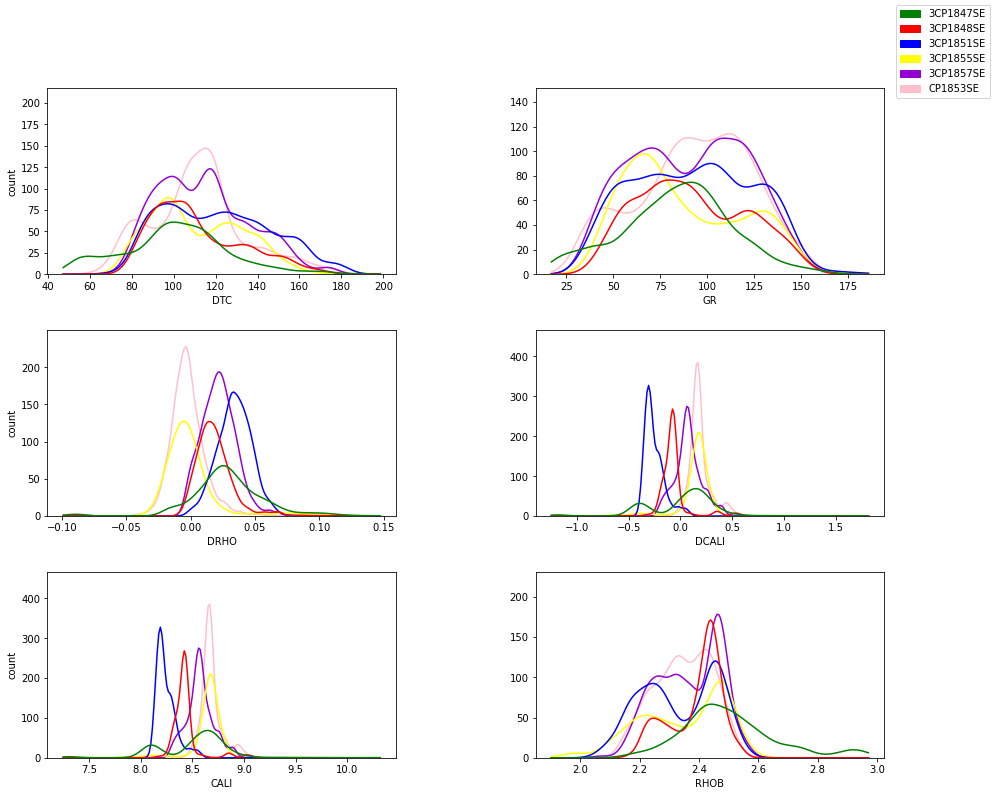

In [ ]:
plotFreq(dlis_concat)

In [ ]:
# Plota a frequência das curvas NPHI, PE, HMRS, LLS, HDRS e LLD nos seis poços

def plotFreq2(dlis_concat):
    f, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,12))

    f.subplots_adjust(top=0.9,
                    wspace=0.4,
                     hspace = 0.3)

    verde = mpatches.Patch(color='green', label='3CP1847SE')
    verm = mpatches.Patch(color='red', label='3CP1848SE')
    azul = mpatches.Patch(color='blue', label='3CP1851SE')
    amar = mpatches.Patch(color='yellow', label='3CP1855SE')
    roxo = mpatches.Patch(color='darkviolet', label='3CP1857SE')
    rosa = mpatches.Patch(color='pink', label='CP1853SE')

    pocos_cores = ['green', 'red', 'blue', 'yellow', 'darkviolet', 'pink']

    # Linha 1 de graficos
    # NPHI
    sns.histplot(data=dlis_concat, x="NPHI", hue="Poco", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[0,0], fill = False, linewidth = 0, legend = False)

    # GR
    #sns.histplot(data=dlis_concat, x="GR", hue="Poco", palette = pocos_cores, stat = "count",
     #            kde = True, ax=axes[0,1], fill = False, linewidth = 0, legend = False)


    # Linha 2 de graficos
    # PE
    sns.histplot(data=dlis_concat, x="PE", hue="Poco", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[0,1], fill = False, linewidth = 0, legend = False)

    # PE
    #sns.histplot(data=dlis_concat, x="DCALI", hue="Poco", palette = pocos_cores, stat = "frequency",
     #            kde = True, ax=axes[1, 1], fill = False, linewidth = 0, legend = False)

    #Linha 3 de gráficos
    # HMRS
    sns.histplot(data=dlis_concat, x="HMRS", hue="Poco", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[1,0], fill = False, linewidth = 0, legend = False)

    # LLS
    sns.histplot(data=dlis_concat, x="LLS", hue="Poco", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[1,1], fill = False, linewidth = 0, legend = False)

    #Linha 4 de gráficos
    # HMRS
    sns.histplot(data=dlis_concat, x="HDRS", hue="Poco", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[2,0], fill = False, linewidth = 0, legend = False)

    # LLD
    sns.histplot(data=dlis_concat, x="LLD", hue="Poco", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[2,1], fill = True, linewidth = 0, legend = False)


    #Excluindo o nome do y em todos os graficos

    for i in range(len(axes)):
        for j in range(axes.size // len(axes)):
             axes[i,j].set_ylabel('')

    # Linha 1 de graficos
    axes[0,0].set_ylabel("count")
    axes[0,1].set_xlim(2,8)


    # Linha 2 de graficos
    axes[1,0].set_ylabel("count")
    axes[1,0].set_xlim(0,20)
    axes[1,0].set_ylim(0,200)
    axes[1,1].set_xlim(1,12.5)

    # Linha 3 de graficos
    axes[2,0].set_ylabel("count")
    axes[2,0].set_xlim(0,25)
    axes[2,0].set_ylim(0,200)
    axes[2,1].set_xlim(1,12.5)


    f.legend(handles = [verde, verm, azul, amar, roxo, rosa])

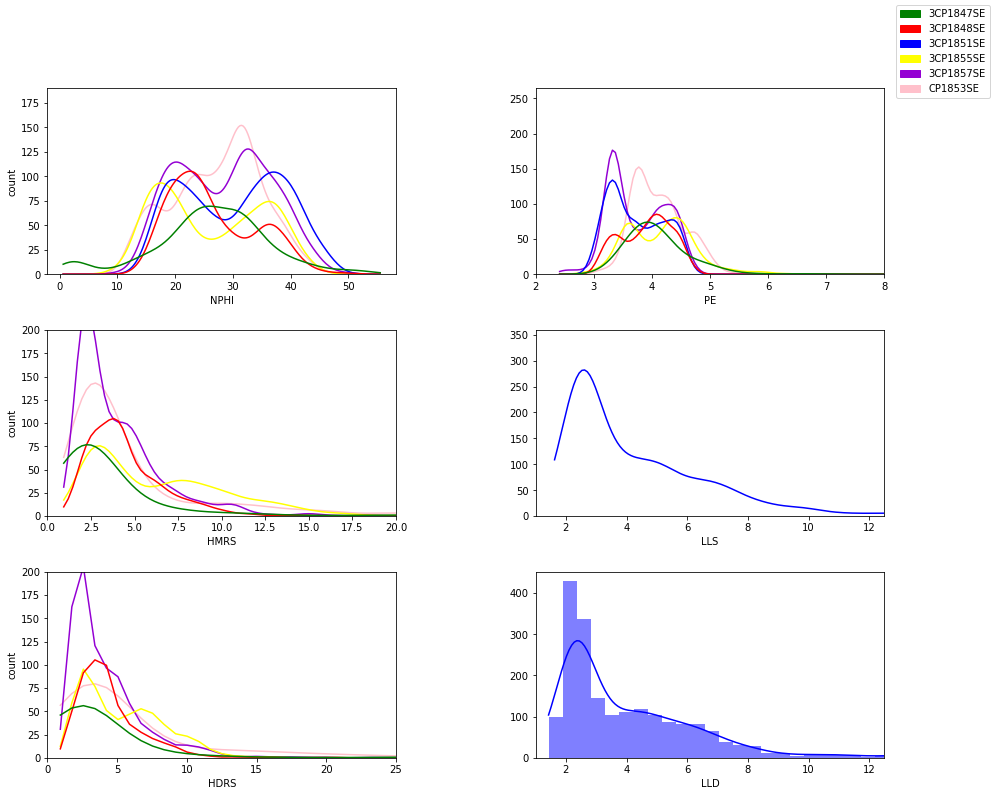

In [ ]:
plotFreq2(dlis_concat)

In [ ]:
# Plota a frequência das curvas HMRS, Log HMRS, HDRS, Log HDRS, LLD, Log LLD, LLS e Log LLS nos seis poços

def plotFreqLog(dlis_concat):
    f, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,12))

    f.subplots_adjust(top=0.9,
                    wspace=0.4,
                     hspace = 0.3)

    verde = mpatches.Patch(color='green', label='3CP1847SE')
    verm = mpatches.Patch(color='red', label='3CP1848SE')
    azul = mpatches.Patch(color='blue', label='3CP1851SE')
    amar = mpatches.Patch(color='yellow', label='3CP1855SE')
    roxo = mpatches.Patch(color='darkviolet', label='3CP1857SE')
    rosa = mpatches.Patch(color='pink', label='CP1853SE')

    pocos_cores = ['green', 'red', 'blue', 'yellow', 'darkviolet', 'pink']

    # Linha 1 de graficos
    # HMRS
    sns.histplot(data=dlis_concat, x="HMRS", hue="Poco", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[0,0], fill = False, linewidth = 0, legend = False)

    #HMRS Log
    sns.histplot(dlis_concat, x=np.log(dlis_concat.HMRS), hue="Poco", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[0,1], fill = False, linewidth = 0, legend = False)

    #Linha 2 de gráficos
    # HDRS
    sns.histplot(data=dlis_concat, x="HDRS", hue="Poco", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[1,0], fill = False, linewidth = 0, legend = False)

    # Log HDRS
    sns.histplot(dlis_concat, x=np.log(dlis_concat.HDRS), hue="Poco", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[1,1], fill = False, linewidth = 0, legend = False)

    # Linha 3 de graficos
    # LLS
    sns.histplot(data=dlis_concat, x="LLS", hue="Poco", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[3,0], fill = False, linewidth = 0, legend = False)

    #Log LLS
    sns.histplot(dlis_concat, x=np.log(dlis_concat.LLS), hue="Poco", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[3,1], fill = False, linewidth = 0, legend = False)

    #Linha 4 de gráficos
    # LLD
    sns.histplot(data=dlis_concat, x="LLD", hue="Poco", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[2,0], fill = False, linewidth = 0, legend = False)

    sns.histplot(dlis_concat, x=np.log(dlis_concat.LLD), hue="Poco", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[2,1], fill = False, linewidth = 0, legend = False)


    #Excluindo o nome do y em todos os graficos

    for i in range(len(axes)):
        for j in range(axes.size // len(axes)):
             axes[i,j].set_ylabel('')

    # Linha 1 de graficos
    axes[0,0].set_ylabel("count")
    axes[0,0].set_xlim(0,20)
    axes[0,0].set_ylim(0,200)
    axes[0,1].set_xlabel("Log HMRS")
    axes[0,1].set_ylim(0,650)

    # Linha 2 de graficos
    axes[1,0].set_ylabel("count")
    axes[1,0].set_xlim(0,25)
    axes[1,0].set_ylim(0,200)
    axes[1,1].set_xlabel("Log HDRS")
    axes[1,1].set_ylim(0,650)

    # Linha 3 de graficos
    axes[2,0].set_ylabel("count")
    axes[2,0].set_ylim(0,650)
    axes[2,1].set_xlabel("Log LLS")

    #Linha 4 de gráficos
    axes[3,0].set_ylabel("count")
    axes[3,1].set_xlabel("Log LLD")
    axes[3,1].set_ylim(0,2300)


    f.legend(handles = [verde, verm, azul, amar, roxo, rosa])

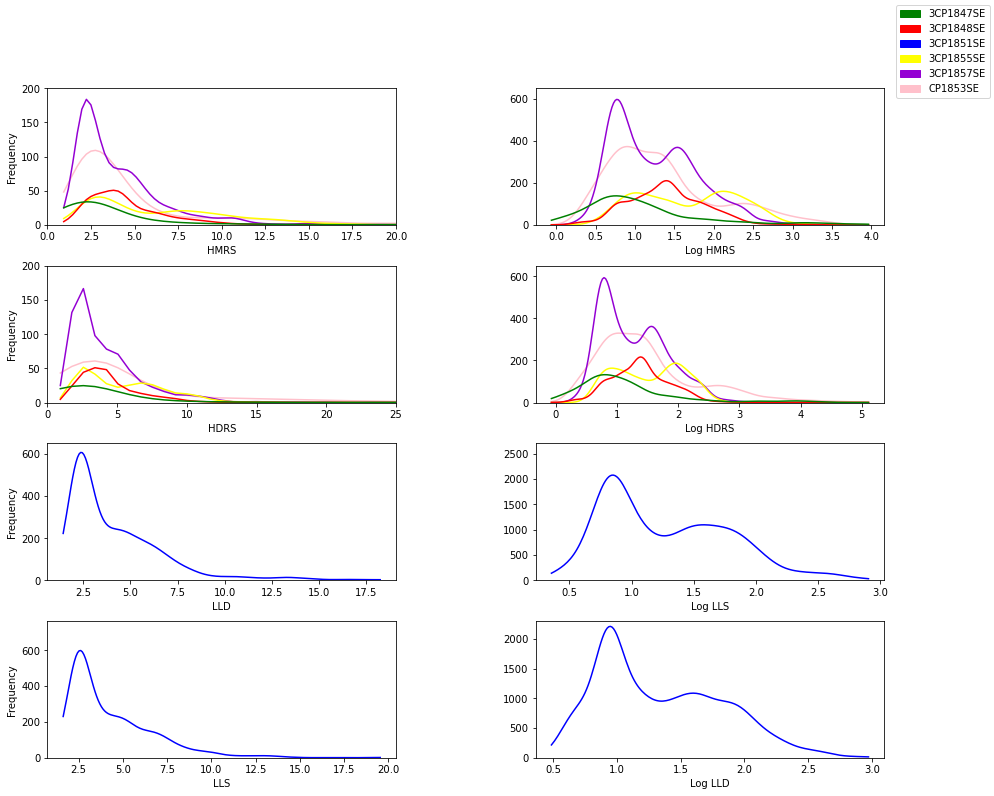

In [ ]:
plotFreqLog(dlis_concat)

In [ ]:
# Plota a frequência das curvas DTC, GR, DRHO, DCALI, CALI, e RHOB nas unidades geológicas TQR, OIT, IBU e MAR

def plotFreqGeo(dlis_concat):
    f, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,12))

    f.subplots_adjust(top=0.9,
                    wspace=0.4,
                     hspace = 0.3)

    verde = mpatches.Patch(color='green', label='TQR')
    verm = mpatches.Patch(color='red', label='OIT')
    azul = mpatches.Patch(color='blue', label='IBU')
    amar = mpatches.Patch(color='yellow', label='MAR')

    pocos_cores = ['green', 'red', 'blue', 'yellow']

    # Linha 1 de graficos
    # DTC
    sns.histplot(data=dlis_concat, x="DTC", hue="n_geo", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[0,0], fill = False, linewidth = 0, legend = False)

    # GR
    sns.histplot(data=dlis_concat, x="GR", hue="n_geo", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[0,1], fill = False, linewidth = 0, legend = False)


    # Linha 2 de graficos
    # DRHO
    sns.histplot(data=dlis_concat, x="DRHO", hue="n_geo", palette = pocos_cores,
                 kde = True, ax=axes[1,0], fill = False, linewidth = 0, legend = False)

    # DCALI
    sns.histplot(data=dlis_concat, x="DCALI", hue="n_geo", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[1, 1], fill = False, linewidth = 0, legend = False)

    #Linha 3 de gráficos
    # CALI
    sns.histplot(data=dlis_concat, x="CALI", hue="n_geo", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[2,0], fill = False, linewidth = 0, legend = False)

    # RHOB
    sns.histplot(data=dlis_concat, x="RHOB", hue="n_geo", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[2,1], fill = False, linewidth = 0, legend = False)


    #Excluindo o nome do y em todos os graficos

    for i in range(len(axes)):
        for j in range(axes.size // len(axes)):
             axes[i,j].set_ylabel('')

    # Linha 1 de graficos
    axes[0,0].set_ylabel("count")


    # Linha 2 de graficos
    axes[1,0].set_ylabel("count")

    # Linha 3 de graficos
    axes[2,0].set_ylabel("count")

    f.legend(handles = [verde, verm, azul, amar])

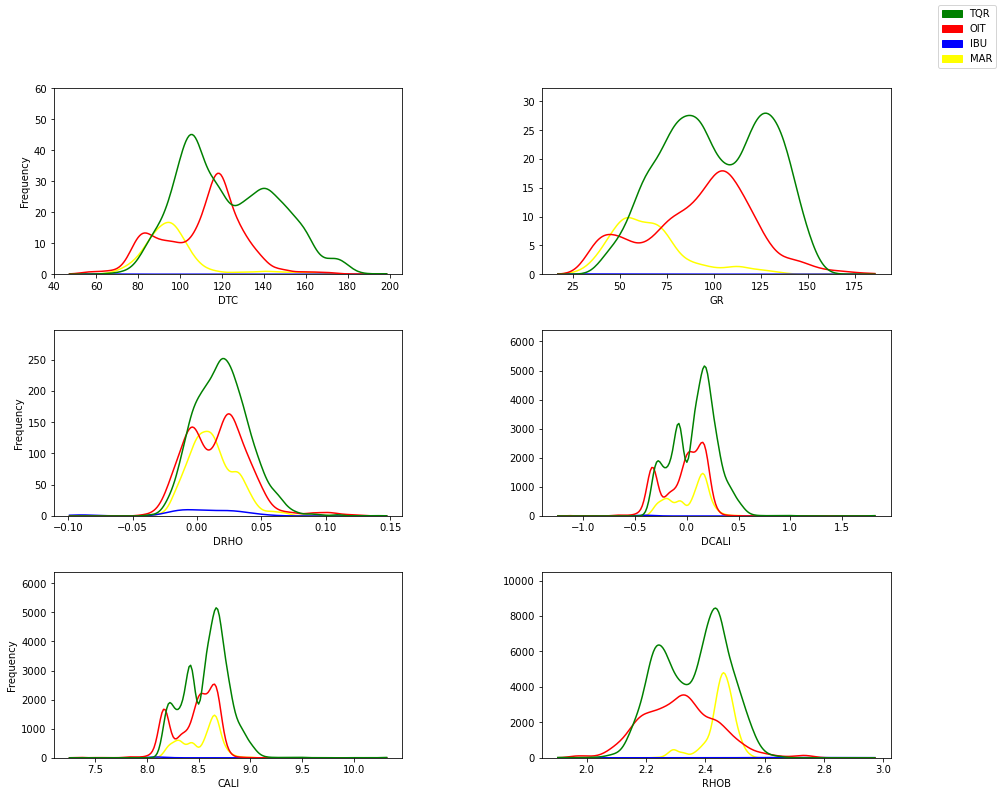

In [ ]:
plotFreqGeo(dlis_concat)

In [ ]:
# Plota a frequência das curvas NPHI, PE, HMRS, LLS e LLD nas unidades geológicas TQR, OIT, IBU e MAR

def plotFreqGeo2(dlis_concat):
    f, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,12))

    f.subplots_adjust(top=0.9,
                    wspace=0.4,
                     hspace = 0.3)

    verde = mpatches.Patch(color='green', label='TQR')
    verm = mpatches.Patch(color='red', label='OIT')
    azul = mpatches.Patch(color='blue', label='IBU')
    amar = mpatches.Patch(color='yellow', label='MAR')

    pocos_cores = ['green', 'red', 'blue', 'yellow']

    # Linha 1 de graficos
    # NPHI
    sns.histplot(data=dlis_concat, x="NPHI", hue="n_geo", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[0,0], fill = False, linewidth = 0, legend = False)



    # Linha 2 de graficos
    # PE
    sns.histplot(data=dlis_concat, x="PE", hue="n_geo", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[0,1], fill = False, linewidth = 0, legend = False)


    #Linha 3 de gráficos
    # HMRS
    sns.histplot(data=dlis_concat, x="HMRS", hue="n_geo", palette = pocos_cores,
                 kde = True, ax=axes[1,0], fill = True, linewidth = 0, legend = False)

    # LLS
    sns.histplot(data=dlis_concat, x="LLS", hue="n_geo", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[1,1], fill = False, linewidth = 0, legend = False)

    #Linha 4 de gráficos
    # HDRS
    sns.histplot(data=dlis_concat, x="HMRS", hue="n_geo", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[2,0], fill = True, linewidth = 0, legend = False)

    # RHOB
    sns.histplot(data=dlis_concat, x="LLD", hue="n_geo", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[2,1], fill = False, linewidth = 0, legend = False)


    #Excluindo o nome do y em todos os graficos

    for i in range(len(axes)):
        for j in range(axes.size // len(axes)):
             axes[i,j].set_ylabel('')

    # Linha 1 de graficos
    axes[0,0].set_ylabel("count")
    #axes[0,1].set_xlim(2,8)


    # Linha 2 de graficos
    axes[1,0].set_ylabel("count")
    axes[1,0].set_xlim(0,20)
    axes[1,0].set_ylim(0,550)
    #axes[1,1].set_xlim(1,12.5)

    # Linha 3 de graficos
    axes[2,0].set_ylabel("count")
    axes[2,0].set_xlim(0,25)
    #axes[2,1].set_xlim(1,12.5)


    f.legend(handles = [verde, verm, azul, amar])

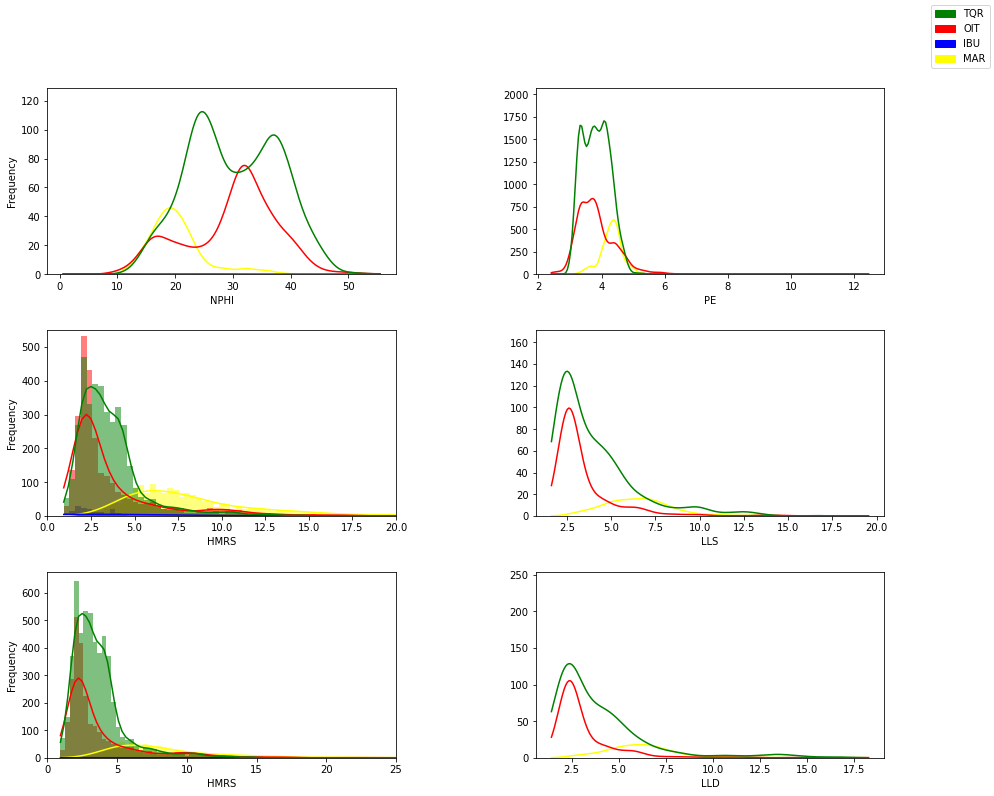

In [ ]:
plotFreqGeo2(dlis_concat)

In [ ]:
# Plota a frequência das curvas NPHI, PE, HMRS e HDRS na unidade geológica IBU

def plotFreqGeo3(dlis_concat):
    f, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,12))

    f.subplots_adjust(top=0.9,
                    wspace=0.4,
                     hspace = 0.3)

    azul = mpatches.Patch(color='blue', label='IBU')

    # Linha 1 de graficos
    # NPHI
    sns.histplot(data=dlis_concat, x="NPHI", color = 'blue', stat = "count",
                 kde = True, ax=axes[0,0], fill = False, linewidth = 0, legend = False)



    # Linha 2 de graficos
    # PE
    sns.histplot(data=dlis_concat, x="PE", color = 'blue', stat = "count",
                 kde = True, ax=axes[0,1], fill = False, linewidth = 0, legend = False)


    #Linha 3 de gráficos
    # HMRS
    sns.histplot(data=dlis_concat, x="HMRS", color = 'blue', stat = "count",
                 kde = True, ax=axes[1,0], fill = False, linewidth = 0, legend = False)


    #Linha 4 de gráficos
    # HMRS
    sns.histplot(data=dlis_concat, x="HDRS", color = 'blue', stat = "count",
                 kde = True, ax=axes[1,1], fill = False, linewidth = 0, legend = False)



    #Excluindo o nome do y em todos os graficos

    for i in range(len(axes)):
        for j in range(axes.size // len(axes)):
             axes[i,j].set_ylabel('')

    # Linha 1 de graficos
    axes[0,0].set_ylabel("count")
    #axes[0,1].set_xlim(2,8)


    # Linha 2 de graficos
    axes[1,0].set_ylabel("count")
    #axes[1,0].set_xlim(0,20)
    #axes[1,0].set_ylim(0,550)
    #axes[1,1].set_xlim(1,12.5)

    # Linha 3 de graficos
    #axes[2,0].set_ylabel("count")
    #axes[2,0].set_xlim(0,25)
    #axes[2,1].set_xlim(1,12.5)


    f.legend(handles = [azul])

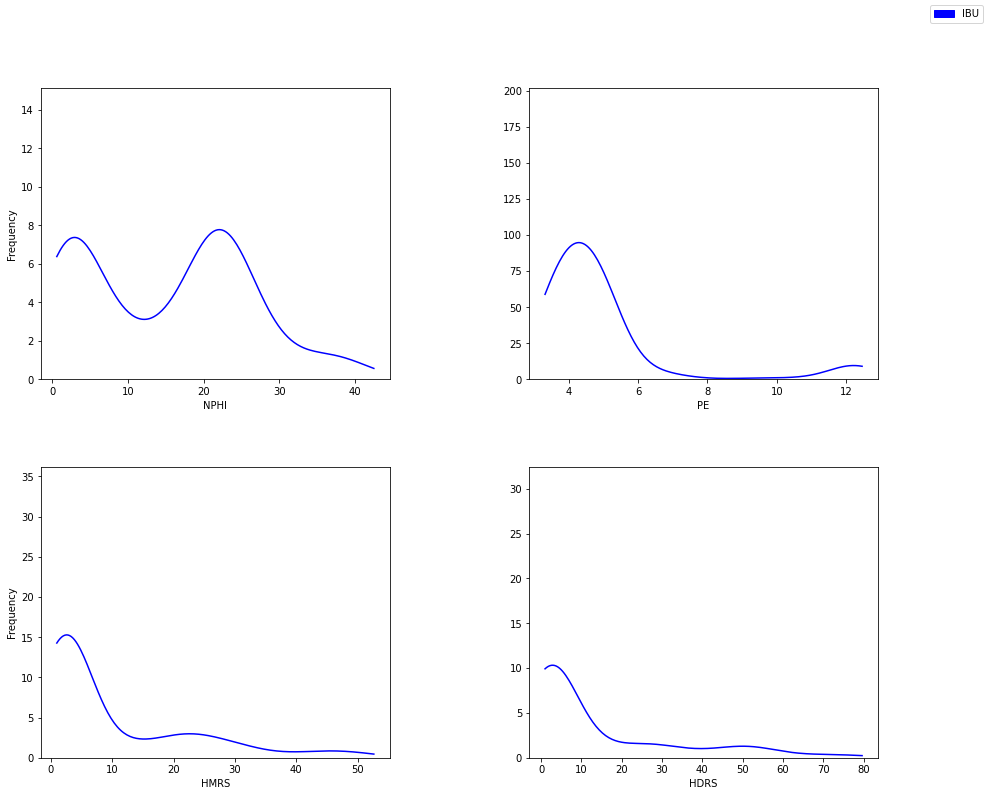

In [ ]:
IBU = dlis_concat[dlis_concat['n_geo'] == 'IBU']
plotFreqGeo3(IBU)

In [ ]:
# Plota a frequência das curvas DTC, GR, DHRO, DCALI, CALI e RHOB na unidade geológica IBU

def plotFreqGeo4(dlis_concat):
    f, axes = plt.subplots(nrows=3, ncols=2, figsize=(15,12))

    f.subplots_adjust(top=0.9,
                    wspace=0.4,
                     hspace = 0.3)

    azul = mpatches.Patch(color='blue', label='IBU')

    # Linha 1 de graficos
    # DTC
    sns.histplot(data=dlis_concat, x="DTC", color = 'blue', stat = "count",
                 kde = True, ax=axes[0,0], fill = False, linewidth = 0, legend = False)

    # GR
    sns.histplot(data=dlis_concat, x="GR", color = 'blue', stat = "count",
                 kde = True, ax=axes[0,1], fill = False, linewidth = 0, legend = False)


    # Linha 2 de graficos
    # DRHO
    sns.histplot(data=dlis_concat, x="DRHO", color = 'blue', stat = "count",
                 kde = True, ax=axes[1,0], fill = False, linewidth = 0, legend = False)

    # DCALI
    sns.histplot(data=dlis_concat, x="DCALI", color = 'blue', stat = "count",
                 kde = True, ax=axes[1, 1], fill = False, linewidth = 0, legend = False)

    #Linha 3 de gráficos
    # CALI
    sns.histplot(data=dlis_concat, x="CALI", color = 'blue', stat = "count",
                 kde = True, ax=axes[2,0], fill = False, linewidth = 0, legend = False)

    # RHOB
    sns.histplot(data=dlis_concat, x="RHOB", color = 'blue', stat = "count",
                 kde = True, ax=axes[2,1], fill = False, linewidth = 0, legend = False)


    #Excluindo o nome do y em todos os graficos

    for i in range(len(axes)):
        for j in range(axes.size // len(axes)):
             axes[i,j].set_ylabel('')

    # Linha 1 de graficos
    axes[0,0].set_ylabel("count")


    # Linha 2 de graficos
    axes[1,0].set_ylabel("count")

    # Linha 3 de graficos
    axes[2,0].set_ylabel("count")

    f.legend(handles = [azul])

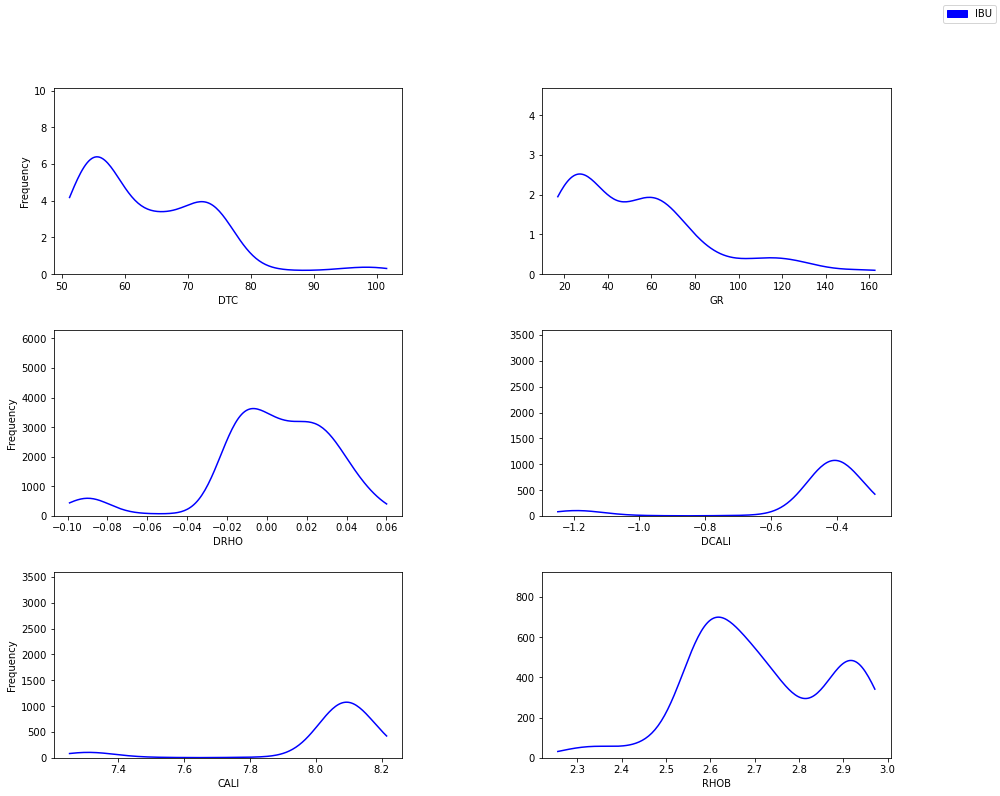

In [ ]:
IBU = dlis_concat[dlis_concat['n_geo'] == 'IBU']
plotFreqGeo4(IBU)

In [ ]:
# Plota a frequência das curvas HRMS, Log HMRS, HDRS, Log HDRS, LLD, Log LLD, LLS e Log LLS nas unidades geológicas TQR, OIT, IBU e MAR

def plotFreqLogGeo(dlis_concat):
    f, axes = plt.subplots(nrows=4, ncols=2, figsize=(15,12))

    f.subplots_adjust(top=0.9,
                    wspace=0.4,
                     hspace = 0.3)

    verde = mpatches.Patch(color='green', label='TQR')
    verm = mpatches.Patch(color='red', label='OIT')
    azul = mpatches.Patch(color='blue', label='IBU')
    amar = mpatches.Patch(color='yellow', label='MAR')

    pocos_cores = ['green', 'red', 'blue', 'yellow']

    # Linha 1 de graficos
    # HMRS
    sns.histplot(data=dlis_concat, x="HMRS", hue="n_geo", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[0,0], fill = False, linewidth = 0, legend = False, bins = 150)

    #HMRS Log
    sns.histplot(dlis_concat, x=np.log(dlis_concat.HMRS), hue="n_geo", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[0,1], fill = False, linewidth = 0, legend = False)

    #Linha 2 de gráficos
    # HDRS
    sns.histplot(data=dlis_concat, x="HDRS", hue="n_geo", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[1,0], fill = False, linewidth = 0, legend = False)

    # Log HDRS
    sns.histplot(dlis_concat, x=np.log(dlis_concat.HDRS), hue="n_geo", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[1,1], fill = False, linewidth = 0, legend = False)

    # Linha 3 de graficos
    # LLS
    sns.histplot(data=dlis_concat, x="LLS", hue="n_geo", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[3,0], fill = False, linewidth = 0, legend = False)

    #Log LLS
    sns.histplot(dlis_concat, x=np.log(dlis_concat.LLS), hue="n_geo", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[3,1], fill = False, linewidth = 0, legend = False)

    #Linha 4 de gráficos
    # LLD
    sns.histplot(data=dlis_concat, x="LLD", hue="n_geo", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[2,0], fill = False, linewidth = 0, legend = False)

    sns.histplot(dlis_concat, x=np.log(dlis_concat.LLD), hue="n_geo", palette = pocos_cores, stat = "count",
                 kde = True, ax=axes[2,1], fill = False, linewidth = 0, legend = False)


    #Excluindo o nome do y em todos os graficos

    for i in range(len(axes)):
        for j in range(axes.size // len(axes)):
             axes[i,j].set_ylabel('')

    # Linha 1 de graficos
    axes[0,0].set_ylabel("count")
    axes[0,0].set_xlim(0,20)
    axes[0,0].set_ylim(0,450)
    axes[0,1].set_xlabel("Log HMRS")

    # Linha 2 de graficos
    axes[1,0].set_ylabel("count")
    #axes[1,0].set_xlim(0,25)
    axes[1,1].set_xlabel("Log HDRS")

    # Linha 3 de graficos
    axes[2,0].set_ylabel("count")
    #axes[2,0].set_xlim(0,15)
    axes[2,1].set_xlabel("Log LLS")

    #Linha 4 de gráficos
    axes[3,0].set_ylabel("count")
    #axes[3,0].set_xlim(0,15)
    axes[3,1].set_xlabel("Log LLD")


    f.legend(handles = [verde, verm, azul, amar])

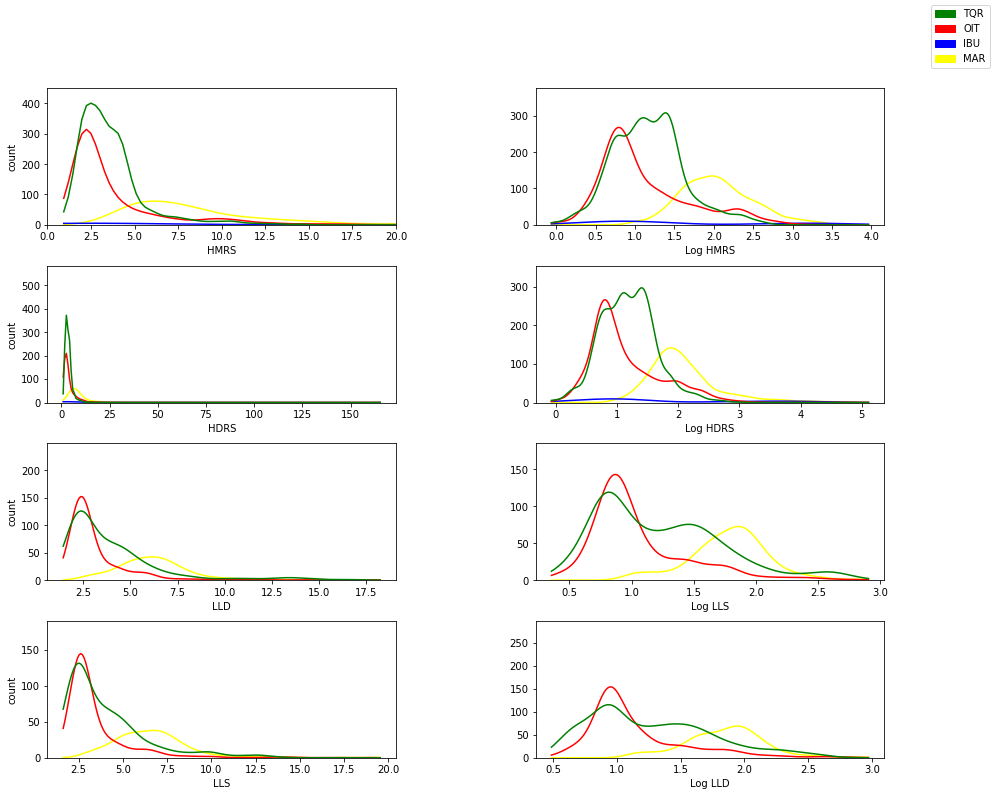

In [ ]:
plotFreqLogGeo(dlis_concat)

In [ ]:
# Plota a frequência das curvas HMRS, Log HMRS, HDRS e Log HDRS na unidade geológica IBU

def plotFreqLogGeoIBU(dlis_concat):
    f, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,12))

    f.subplots_adjust(top=0.9,
                    wspace=0.4,
                     hspace = 0.3)

    azul = mpatches.Patch(color='blue', label='IBU')

    # Linha 1 de graficos
    # HMRS
    sns.histplot(data=dlis_concat, x="HMRS", color = 'blue', stat = "count",
                 kde = True, ax=axes[0,0], fill = False, linewidth = 0, legend = False)

    #HMRS Log
    sns.histplot(dlis_concat, x=np.log(dlis_concat.HMRS), color = 'blue', stat = "count",
                 kde = True, ax=axes[0,1], fill = False, linewidth = 0, legend = False)

    #Linha 2 de gráficos
    # HDRS
    sns.histplot(data=dlis_concat, x="HDRS", color = 'blue', stat = "count",
                 kde = True, ax=axes[1,0], fill = False, linewidth = 0, legend = False)

    # Log HDRS
    sns.histplot(dlis_concat, x=np.log(dlis_concat.HDRS), color = 'blue', stat = "count",
                 kde = True, ax=axes[1,1], fill = False, linewidth = 0, legend = False)


    #Excluindo o nome do y em todos os graficos

    for i in range(len(axes)):
        for j in range(axes.size // len(axes)):
             axes[i,j].set_ylabel('')

    # Linha 1 de graficos
    axes[0,0].set_ylabel("count")
    #axes[0,0].set_xlim(0,20)
    axes[0,1].set_xlabel("Log HMRS")

    # Linha 2 de graficos
    axes[1,0].set_ylabel("count")
    #axes[1,0].set_xlim(0,25)
    axes[1,1].set_xlabel("Log HDRS")


    f.legend(handles = [azul])

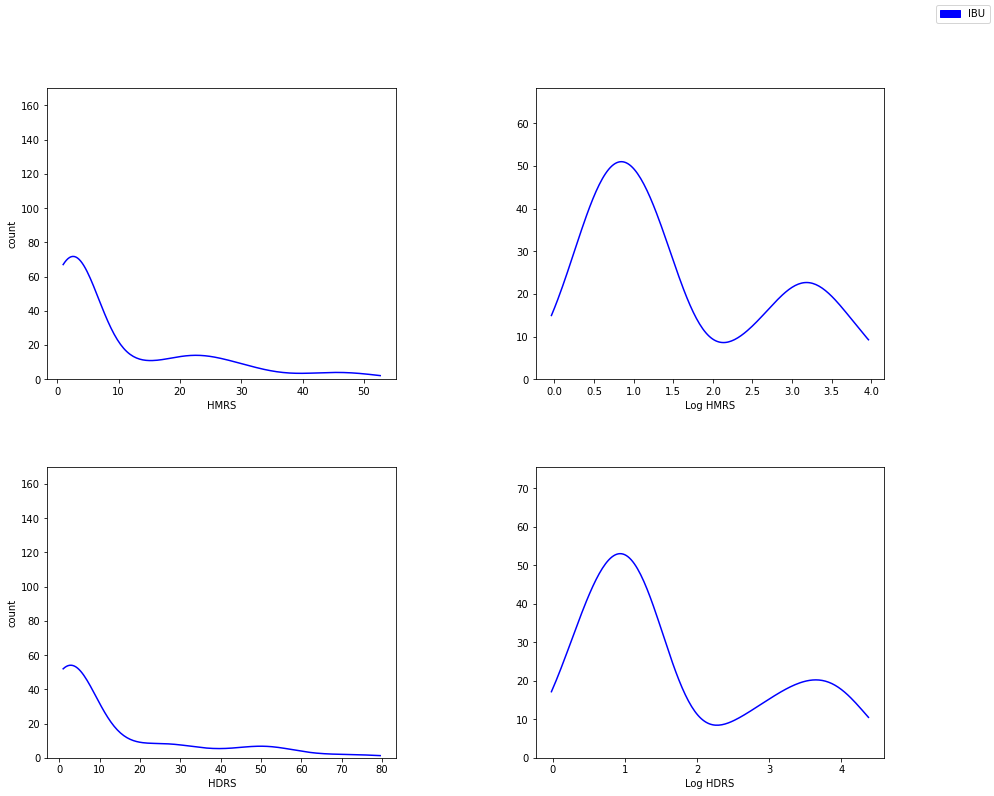

In [ ]:
IBU = dlis_concat[dlis_concat['n_geo'] == 'IBU']
plotFreqLogGeoIBU(IBU)

<AxesSubplot:xlabel='RHOB', ylabel='Frequency'>

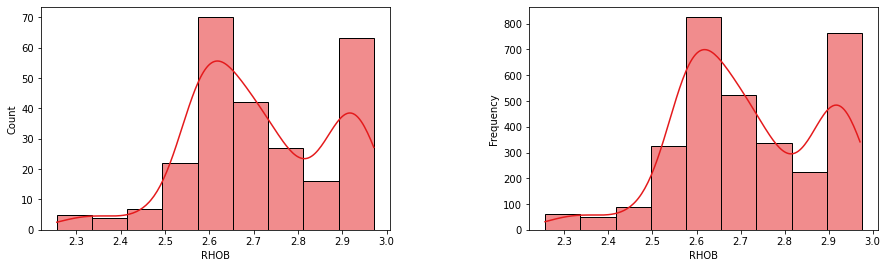

In [ ]:
# Plota Histograma da densidade (RHOB) da coluna ‘n_geo’

f, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

f.subplots_adjust(top=0.9,
                wspace=0.4,
                 hspace = 0.3)

sns.histplot(data=IBU, x="RHOB", hue="n_geo", palette = "Set1",
                 kde = True, fill = True, linewidth = 1, legend = False, ax = axes[0])

sns.histplot(data=IBU, x="RHOB", hue="n_geo", palette = "Set1", stat = "frequency",
                 kde = True, fill = True, linewidth = 1, legend = False, binwidth = 0.08, ax = axes[1])

<AxesSubplot:xlabel='RHOB', ylabel='Frequency'>

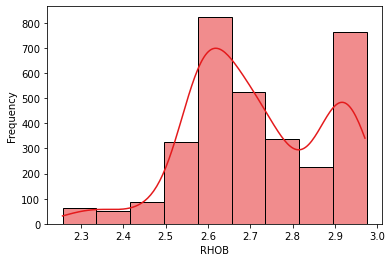

In [ ]:
# Similar a 29

sns.histplot(data=IBU, x="RHOB", hue="n_geo", palette = "Set1", stat = "frequency",
                 kde = True, fill = True, linewidth = 1, legend = False, binwidth = 0.08)#,  binwidth = 1)
